In [2]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns 
import scanpy as sc
import scipy as sp
import numpy as np
import anndata
import pySingleCellNet as pySCN
sns.set_style('white')

In [60]:
# read in data
adata_mcm=sc.read_h5ad('direct_conversion_subsampled_5k.h5ad')
adata_tabmuris=sc.read_h5ad('TM_FACS_heart.h5ad')

In [61]:
adata_mcm #this object is our enginered cardiomyocyte data

AnnData object with n_obs × n_vars = 5000 × 33595
    obs: 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'batch_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [63]:
adata_mcm.obs['Timepoint (days)']=adata_mcm.obs['batch'].map({'1':'-1','2':'1','3':'2','4':'3','5':'7','6':'14'})

In [64]:
#qc metrics for oldhsc
adata_mcm.var['mt']= adata_mcm.var_names.str.startswith(("mt-"))
adata_mcm.var['ribo'] = adata_mcm.var_names.str.startswith(("Rps","Rpl"))
sc.pp.calculate_qc_metrics(adata_mcm, qc_vars=['ribo', 'mt'], percent_top=None, log1p=False, inplace=True)

In [65]:
genesTrain = adata_tabmuris.var_names
genesQuery = adata_mcm.var_names
cgenes = genesTrain.intersection(genesQuery)
#around 14k genes remanining

In [66]:
#subsetting for common genes
adata_reference_cgene = adata_tabmuris[:,cgenes]
adata_mcm = adata_mcm[:,cgenes].copy()

#following the pyscCellNet vignette on github. im guessing cells with more than 500 
adata_mcm_classifier = adata_mcm[adata_mcm.obs["n_genes_by_counts"]>=500,:].copy()




In [67]:
adata_reference_cgene.obs['cell_ontology_class'].unique()

['endothelial cell', 'leukocyte', 'fibroblast', 'myofibroblast cell', 'endocardial cell', 'cardiac muscle cell', 'smooth muscle cell']
Categories (7, object): ['cardiac muscle cell', 'endocardial cell', 'endothelial cell', 'fibroblast', 'leukocyte', 'myofibroblast cell', 'smooth muscle cell']

In [68]:
expTrain, expVal = pySCN.splitCommonAnnData(adata_reference_cgene, ncells=200,dLevel='cell_ontology_class')



myofibroblast cell : 
178
endocardial cell : 
165
endothelial cell : 
1177
cardiac muscle cell : 
133
fibroblast : 
2119
leukocyte : 
523
smooth muscle cell : 
42


In [69]:
[cgenesA, xpairs, tspRF] = pySCN.scn_train(expTrain, nTopGenes = 100, nRand = 100,
                                           nTrees = 1000 ,nTopGenePairs = 100, dLevel = 'cell_ontology_class', 
                                           stratify=True, limitToHVG=True)

HVG
Matrix normalized
There are  743  classification genes

cardiac muscle cell
endocardial cell
endothelial cell
fibroblast
leukocyte
myofibroblast cell
smooth muscle cell
There are 692 top gene pairs

Finished pair transforming the data



<Figure size 6000x4000 with 0 Axes>

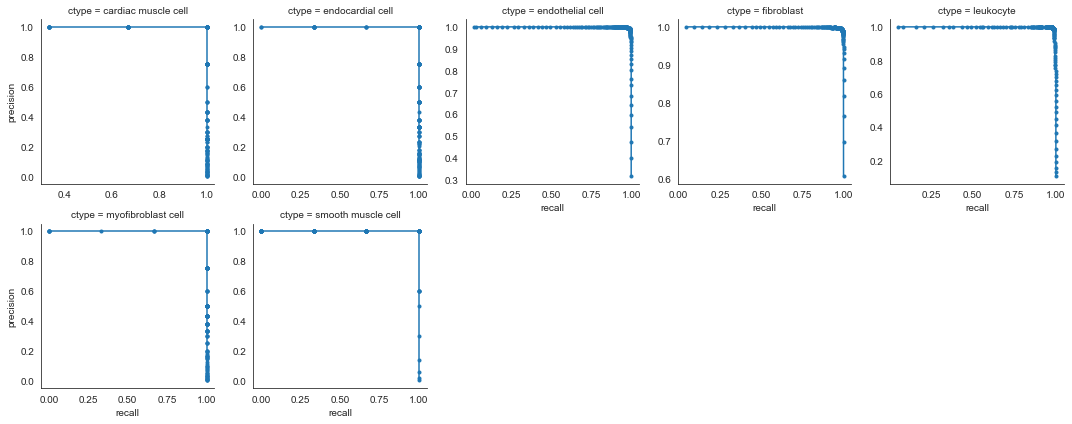

<Figure size 432x288 with 0 Axes>

In [209]:
#classifier on held out test set
plt.figure(dpi=1000)
adVal = pySCN.scn_classify(expVal, cgenesA, xpairs, tspRF, nrand = 0)
assessment =  pySCN.assess_comm(expTrain, adVal, resolution = 0.005, nRand = 0, dLevelSID = "cell", classTrain = "cell_ontology_class", classQuery = "cell_ontology_class")

pySCN.plot_PRs(assessment)
plt.show()
plt.savefig("pyscn_testsetprc.png") #save as png

In [71]:
#use classifier on old hsc data
adata_mcm_classified = pySCN.scn_classify(adata_mcm_classifier, cgenesA, xpairs, tspRF, nrand = 0)



In [128]:
props={}
for i in adata_mcm_classified.obs['Timepoint (days)'].unique():
    props[i]={}
    for j in adata_mcm_classified[adata_mcm_classified.obs['Timepoint (days)']==i].obs['SCN_class'].unique():
        props[i][j]=sum(adata_mcm_classified[adata_mcm_classified.obs['Timepoint (days)']==i].obs['SCN_class']==j)

In [140]:
scn_calls=pd.DataFrame(props).fillna(0)
scn_calls.update(scn_calls.div(scn_calls.sum(axis=0),axis=1))
scn_calls=scn_calls[['-1','1','2','3','7','14']]

In [141]:
scn_calls

,-1,1,2,3,7,14
cardiac muscle cell,0.000000,0.000000,0.006148,0.026362,0.075736,0.391705
rand,0.829493,0.904523,0.877049,0.855009,0.713885,0.557604
leukocyte,0.075269,0.087102,0.099727,0.094903,0.165498,0.050691
fibroblast,0.093702,0.006700,0.015710,0.016696,0.040673,0.000000
endothelial cell,0.000000,0.000000,0.000000,0.000000,0.001403,0.000000
endocardial cell,0.001536,0.001675,0.001366,0.007030,0.002805,0.000000


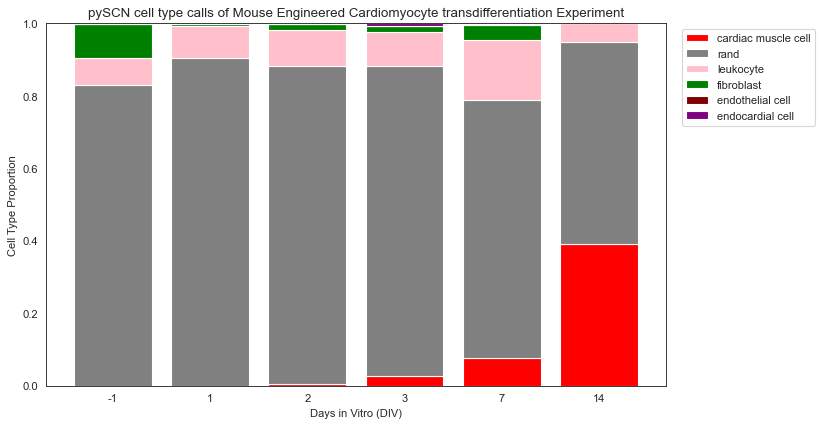

In [208]:
plt.figure(figsize=(10, 6), dpi=80)

plt.bar(scn_calls.columns,scn_calls.loc['cardiac muscle cell'],color='red')
plt.bar(scn_calls.columns, scn_calls.loc['rand'], bottom=scn_calls.loc['cardiac muscle cell'], color='grey')
plt.bar(scn_calls.columns, scn_calls.loc['leukocyte'], bottom=scn_calls.loc['cardiac muscle cell']+scn_calls.loc['rand'], color='pink')
plt.bar(scn_calls.columns, scn_calls.loc['fibroblast'], bottom=scn_calls.loc['leukocyte']+scn_calls.loc['cardiac muscle cell']+scn_calls.loc['rand'], color='green')
plt.bar(scn_calls.columns, scn_calls.loc['endothelial cell'], bottom=scn_calls.loc['leukocyte']+scn_calls.loc['cardiac muscle cell']+scn_calls.loc['rand']+scn_calls.loc['fibroblast'], color='maroon')
plt.bar(scn_calls.columns, scn_calls.loc['endocardial cell'], bottom=scn_calls.loc['leukocyte']+scn_calls.loc['cardiac muscle cell']+scn_calls.loc['rand']+scn_calls.loc['fibroblast']+scn_calls.loc['endothelial cell'], color='purple')


plt.legend(["cardiac muscle cell", "rand", "leukocyte", "fibroblast",'endothelial cell','endocardial cell'],loc='upper right',bbox_to_anchor=(1.25, 1.0))
plt.xlabel('Days in Vitro (DIV)')
plt.ylabel('Cell Type Proportion')
plt.title('pySCN cell type calls of Mouse Engineered Cardiomyocyte transdifferentiation Experiment')
plt.savefig("pyscn_stackedbarplot.png") #save as png
